In [37]:
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.plugins.init_dptb import InitDPTBModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost, DPTBHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
from ase.io.trajectory import Trajectory
import pickle as pickle
#"seed": 3982377700,
from dptb.postprocess.NEGF import NEGF


# Check Band Structure

# initial rotate H or S func.


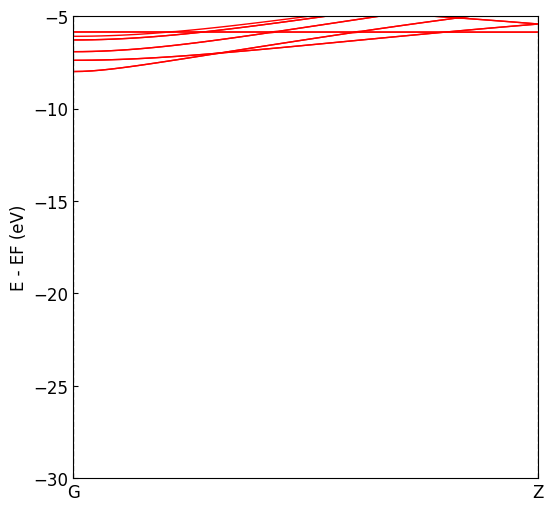

In [50]:
checkfile = './best_nnsk_c3.0w0.01.json'
#checkfile = "./inputSiGe.json"
nnskapi = NNSKHost(checkpoint=checkfile, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')
run_opt={"structure":"/data/DFT/CNT/CNT40/PRIMCELL.vasp",
        "results_path":"./"}
jdata={
        "kline_type":"abacus",
        "kpath":[[0.0000000000, 0.0000000000, 0.0000000000, 50],
                 [0.0000000000, 0.0000000000, 0.5000000000, 1]
                 ],
        "klabels":['G','Z'],
        "emin":-10,
        "emax":10
        }
bcalc = bandcalc(apiHrk=nnHrk,run_opt=run_opt,jdata=jdata)
eigenstatus = bcalc.get_bands()

band = np.loadtxt('./BANDS_1.dat')

plt.figure(figsize=(6,6),dpi=100)
#plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues'] - eigenstatus['E_fermi'], 'r-',lw=1)
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues'][:,80:], 'r-',lw=1)
# plt.plot(band['xcoords'],band['eigenvalues']-np.min(band['eigenvalues']),'k--',ms=2)
# plt.plot(eigenstatus['xlist'], band[:,2:] - np.min(band[:,2:]),'k--',lw=1)
plt.ylim(-30,-5)
# plt.axhline(-8.35)


for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
#plt.ylim(emin,emax)

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
#plt.savefig(f'{self.results_path}/band.png',dpi=300)
# plt.axhline(40.0)
plt.show()

# Compute Transmission

In [1]:
jdata = {
        "task": "negf",
        "scf": True,
        "ele_T": 500,
        "unit": "Hartree",
        "read_HS":True,
        "scf_options":{
            "mode": "PDIIS",
            "mixing_period": 3,
            "step_size": 0.05,
            "n_history": 6,
            "abs_err": 1e-6,
            "rel_err": 1e-4,
            "max_iter": 100
        },
        "stru_options":{
            "pbc":[False, False, False],
            "device":{
                "id":"0-160",
                "sort": True
            },
            "lead_L":{
                "id":"160-320",
                "voltage":0.0
            },
            "lead_R":{
                "id":"320-480",
                "voltage":0.0
            },
            "d_trains":"z"
        },
        "poisson_options": {
            "solver": "fmm",
            "err": 1e-5
        },
        "sgf_solver": "Sancho-Rubio",
        "espacing": 0.05,
        "emin": -3,
        "emax": 3,
        "e_fermi": -8.35,
        "eta_lead":1e-5,
        "eta_device":0.0,
        "properties":["DOS", "TC", "density"]
}

In [2]:
!export PYTHONUNBUFFERED=1
crt = './best_nnsk_c3.0w0.01.json'

nnskapi = NNSKHost(checkpoint=crt, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

atom = read("./C.vasp")

run_opt={"structure":atom,
        "results_path":"./"}


negf = NEGF(apiHrk=nnHrk, run_opt=run_opt, jdata=jdata)

NameError: name 'NNSKHost' is not defined

In [5]:
negf.compute_electrode_self_energy()

True

In [6]:
negf.compute_green_function()

True

In [7]:
gtrains = [i[0] for i in negf.green]

TT = []
for i in range(120):
    TT.append(negf.calTT(
        seL=negf.SeE["lead_L"][i],
        seR=negf.SeE["lead_R"][i],
        gtrains=gtrains[i]
    ).data)

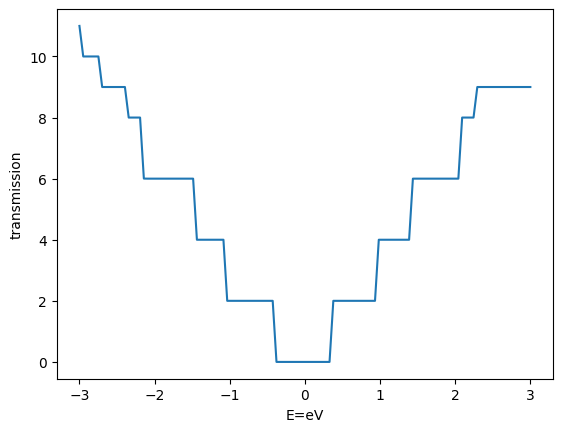

In [8]:

plt.plot(torch.linspace(-3,3,120), TT)
plt.xlabel("E=eV")
plt.ylabel("transmission")
plt.show()

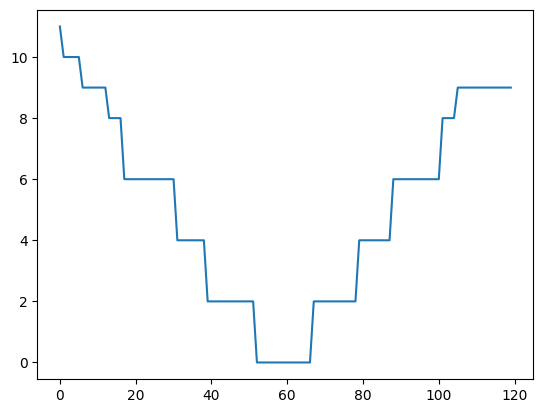

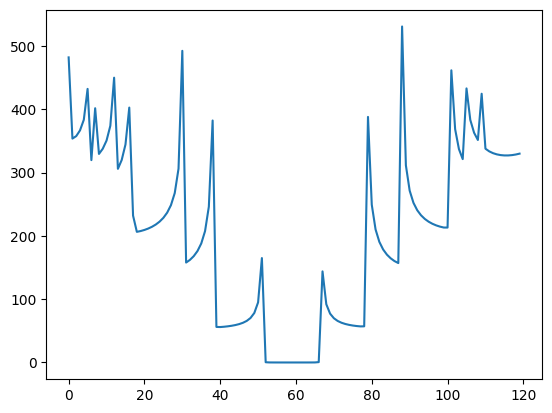

In [6]:
import torch

f=  torch.load("calc/results/properties.pth")
TC = torch.tensor(f["TC"])
import matplotlib.pyplot as plt

plt.plot(TC)
plt.show()

DOS = torch.tensor(f["DOS"])

plt.plot(DOS)
plt.show()

In [9]:
jdata = {
        "task": "negf",
        "scf": True,
        "ele_T": 500,
        "unit": "Hartree",
        "read_HS":True,
        "scf_options":{
            "mode": "PDIIS",
            "mixing_period": 3,
            "step_size": 0.05,
            "n_history": 6,
            "abs_err": 1e-6,
            "rel_err": 1e-4,
            "max_iter": 100
        },
        "stru_options":{
            "kmesh":[1,1,1],
            "pbc":[False, False, False],
            "device":{
                "id":"0-160",
                "sort": True
            },
            "lead_L":{
                "id":"160-320",
                "voltage":0.0
            },
            "lead_R":{
                "id":"320-480",
                "voltage":0.0
            },
            "d_trains":"z"
        },
        "poisson_options": {
            "solver": "fmm",
            "err": 1e-5
        },
        "sgf_solver": "Sancho-Rubio",
        "espacing": 0.05,
        "emin": -3,
        "emax": 3,
        "e_fermi": -8.35,
        "eta_lead":1e-5,
        "eta_device":0.0,
        "properties":["DOS", "TC", "density"]
}

In [10]:
from dptb.negf.hamiltonian import Hamiltonian
import torch
import numpy as np
from dptb.plugins.init_nnsk import InitSKModel
from dptb.plugins.init_dptb import InitDPTBModel
from dptb.nnops.NN2HRK import NN2HRK
from dptb.nnops.apihost import NNSKHost, DPTBHost
from ase.io import read,write
from dptb.structure.structure import BaseStruct
import matplotlib.pyplot as plt
from dptb.postprocess.bandstructure.band import bandcalc
from ase.io.trajectory import Trajectory
import pickle as pickle
#"seed": 3982377700,
from dptb.postprocess.NEGF import NEGF

!export PYTHONUNBUFFERED=1
crt = './best_nnsk_c3.0w0.01.json'

nnskapi = NNSKHost(checkpoint=crt, config="./input.json")
nnskapi.register_plugin(InitSKModel())
nnskapi.build()
nnHrk = NN2HRK(apihost=nnskapi, mode='nnsk')

atom = read("./C.vasp")

h = Hamiltonian(apiH=nnHrk, structase=atom, stru_options=jdata["stru_options"], result_path="./refactor")

with torch.no_grad():
    struct_device, struct_leads = h.initialize(kpoints=[[0,0,0]])

# initial rotate H or S func.


In [11]:
from dptb.negf.Device import Device
from dptb.negf.Lead import Lead

device = Device(h, struct_device, result_path="./refactor/", efermi=jdata["e_fermi"])
device.set_leadLR(
    lead_L=Lead(hamiltonian=h, tab="lead_L", structure=struct_leads["lead_L"], result_path="./refactor/", efermi=jdata["e_fermi"]),
    lead_R=Lead(hamiltonian=h, tab="lead_R", structure=struct_leads["lead_R"], result_path="./refactor/", efermi=jdata["e_fermi"])
    )

In [4]:
ee = torch.linspace(-3,3,151)
with torch.no_grad():
    device.lead_L.self_energy(kpoint=[0,0,0], ee=ee, eta_lead=1e-5)
    device.lead_R.self_energy(kpoint=[0,0,0], ee=ee, eta_lead=1e-5)
    device.green_function(ee=ee, kpoint=[0,0,0], block_tridiagonal=False, etaDevice=1e-5)


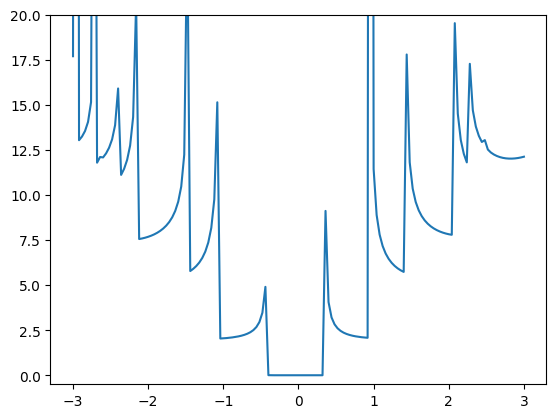

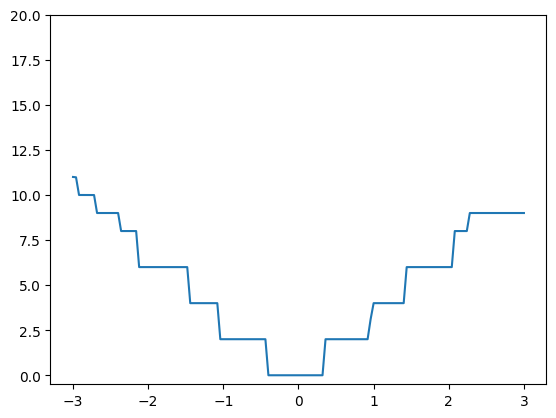

In [5]:
plt.plot(ee.detach(), device.dos.detach().numpy())
plt.ylim([-0.5,20])
plt.show()

plt.plot(ee.detach(), device.tc.detach().numpy())
plt.ylim([-0.5,20])
plt.show()

In [6]:
from dptb.negf.Device import Device
from dptb.negf.Lead import Lead

device = Device(h, struct_device, result_path="./refactor/", efermi=jdata["e_fermi"])
device.set_leadLR(
    lead_L=Lead(hamiltonian=h, tab="lead_L", structure=struct_leads["lead_L"], result_path="./refactor/", efermi=jdata["e_fermi"]),
    lead_R=Lead(hamiltonian=h, tab="lead_R", structure=struct_leads["lead_R"], result_path="./refactor/", efermi=jdata["e_fermi"])
    )

ee = torch.linspace(-22,0,151)
with torch.no_grad():
    device.lead_L.self_energy(kpoint=[0,0,0], ee=ee, eta_lead=1e-5)
    device.lead_R.self_energy(kpoint=[0,0,0], ee=ee, eta_lead=1e-5)
    device.green_function(ee=ee, kpoint=[0,0,0], block_tridiagonal=False, etaDevice=1e-5)


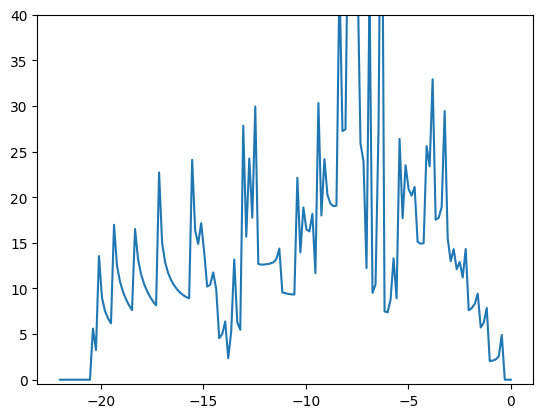

In [11]:
plt.plot(ee.detach(), device.dos.detach().numpy())
plt.ylim([-0.5,40])
plt.show()

In [7]:
from scipy.integrate import simpson

simpson(device.dos, ee)

314.9185963347115

In [12]:
from dptb.negf.density import Ozaki

ozaki = Ozaki(R=1e+6,  M_cut=50, n_gauss=50)
DM_eq, DM_neq = ozaki.integrate(device=device, kpoint=[0,0,0])

tensor(0.+1000000.j, dtype=torch.complex128)
tensor(0.+1000000.j, dtype=torch.complex128)
tensor(-8.3500+0.0812j, dtype=torch.complex128)
tensor(-8.3500+0.5685j, dtype=torch.complex128)
tensor(-8.3500+0.7309j, dtype=torch.complex128)
tensor(-8.3500+0.4061j, dtype=torch.complex128)
tensor(-8.3500+0.8934j, dtype=torch.complex128)
tensor(-8.3500+23.8417j, dtype=torch.complex128)
tensor(-8.3500+2.0304j, dtype=torch.complex128)
tensor(-8.3500+2.1928j, dtype=torch.complex128)
tensor(-8.3500+2.3553j, dtype=torch.complex128)
tensor(-8.3500+2.5177j, dtype=torch.complex128)
tensor(-8.3500+2.8426j, dtype=torch.complex128)
tensor(-8.3500+2.6801j, dtype=torch.complex128)
tensor(-8.3500+4.1420j, dtype=torch.complex128)
tensor(-8.3500+4.3045j, dtype=torch.complex128)
tensor(-8.3500+4.4669j, dtype=torch.complex128)
tensor(-8.3500+4.6294j, dtype=torch.complex128)
tensor(-8.3500+4.7921j, dtype=torch.complex128)
tensor(-8.3500+4.9575j, dtype=torch.complex128)
tensor(-8.3500+6.1790j, dtype=torch.complex12

In [ ]:
from dptb.negf.density import Ozaki

ozaki = Ozaki(R=1e+6,  M_cut=100, n_gauss=50)
DM_eq2, DM_neq2 = ozaki.integrate(device=device, kpoint=[0,0,0])

In [14]:
import matplotlib.pyplot as plt
print(DM_eq.diag().sum())
print(DM_eq.diag().view(160,-1)[0:2])

tensor(640.0000, dtype=torch.float64)
tensor([[1.1930, 1.0005, 0.8806, 0.8842, 0.0416],
        [1.1930, 1.0005, 0.8806, 0.8842, 0.0416]], dtype=torch.float64)


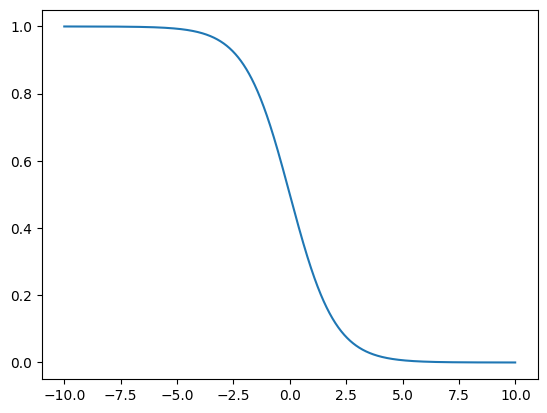

In [8]:
import numpy as np
import torch
from scipy.linalg import eigh_tridiagonal
def ozaki_residues(M_cut:int=1000):
    """
    It computes the poles and residues of the Ozaki formulism.

    Parameters
    ----------
    M_cut (int (optional)): The cutoff, i.e. 2 * M_cut is dimension of the Ozaki matrix.

    Returns
    -------
    poles: The positive half of poles, in ascending order.
    res: The residues of positive half of poles.
    """
    if not isinstance(M_cut, int):
        M_cut = int(M_cut)
    # diagonal part of Ozaki matrix

    N_curt = int(2 * M_cut)
    diag = np.zeros(N_curt)
    # off-diagonal part of Ozaki matrix
    off_diag = np.array([.5 / np.sqrt((2. * n - 1) * (2. * n + 1)) for n in range(1, N_curt)])
    # The reciprocal of poles (eigenvalues) are in numerically ascending order, we just need the positive half.
    evals, evecs = eigh_tridiagonal(d=diag, e=off_diag, select='i', select_range=(N_curt // 2, N_curt - 1))
    # return poles in ascending order
    poles = np.flip(1. / evals)
    # compute residues
    res = np.flip(np.abs(evecs[0, :]) ** 2 / (4. * evals ** 2))

    return torch.from_numpy(poles.copy()), torch.from_numpy(res.copy())

poles, res = ozaki_residues(M_cut=100)

def f(x):
    return 0.5 - (res / (x - 1j * poles)).sum() - (res / (x + 1j * poles)).sum()

import matplotlib.pyplot as plt

ee = [i * 0.01 for i in range(-1000, 1000)]
fn = [f(i) for i in ee]

plt.plot(ee, fn)
plt.show()

In [22]:
from dptb.negf.density import Ozaki

ozaki = Ozaki(R=1e+6,  M_cut=200, n_gauss=50)
DM_eq4, DM_neq4 = ozaki.integrate(device=device, kpoint=[0,0,0])

In [26]:
(DM_eq4 - DM_eq3).norm(), (DM_eq3 - DM_eq2).norm(), (DM_eq2 - DM_eq).norm()

(tensor(43.5857, dtype=torch.float64),
 tensor(57.8281, dtype=torch.float64),
 tensor(104.0217, dtype=torch.float64),
 tensor(67.7990, dtype=torch.float64))

In [19]:
from dptb.negf.density import Ozaki

ozaki = Ozaki(R=1e+6,  M_cut=300, n_gauss=50)
DM_eq3, DM_neq3 = ozaki.integrate(device=device, kpoint=[0,0,0])

torch.Size([50, 800, 800])


In [15]:
import sympy as sym
import torch

torch.linalg.eigh

def least_squares(f, psi, Omega): 
    N = len(psi) - 1
    A = sym.zeros(N+1, N+1)
    b = sym.zeros(N+1, 1)
    x = sym.Symbol('x')
    for i in range(N+1):
        for j in range(i, N+1):
            A[i,j] = sym.integrate(psi[i]*psi[j], (x, Omega[0], Omega[1]))
            A[j,i] = A[i,j]
        b[i,0] = sym.integrate(psi[i]*f, (x, Omega[0], Omega[1]))
    c = A.LUsolve(b) # Note: c is a sympy Matrix object, solution is in c[:,0] 
    u=0
    for i in range(len(psi)):
        u += c[i,0]*psi[i]
    return u, c

In [26]:
x = sym.Symbol('x')
f = x**5
psi = [x**i for i in range(1,6)]

least_squares(f, psi, (-1,1))

(x**5,
 Matrix([
 [0],
 [0],
 [0],
 [0],
 [1]]))